In [1]:
import sys
import os
from timeit import default_timer as timer
os.getcwd()

'/home/jupyter/Notebooks/crystal/NLP/nlp_testing'

In [6]:
# Adapted from the tutorial at https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/

In [3]:
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
%matplotlib inline

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [4]:
# list(tokenizer.vocab.keys())[5000:5020]
list(tokenizer.vocab.keys())[17733]

'disgusted'

In [47]:
# Define a new example sentence with multiple meanings of the word "disgusted"
text = "[CLS] She made a disgusted pout [SEP] Her disgusted expression was contagious [SEP]"

# Split the sentence into tokens.
tokenized_text = tokenizer.tokenize(text)
print(tokenized_text)

# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indeces.
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

['[CLS]', 'she', 'made', 'a', 'disgusted', 'po', '##ut', '[SEP]', 'her', 'disgusted', 'expression', 'was', 'con', '##tag', '##ious', '[SEP]']
[CLS]           101
she           2,016
made          2,081
a             1,037
disgusted    17,733
po           13,433
##ut          4,904
[SEP]           102
her           2,014
disgusted    17,733
expression    3,670
was           2,001
con           9,530
##tag        15,900
##ious        6,313
[SEP]           102


In [65]:
# Mark each of the tokens as belonging to sentence "0" or "1".

segments_ids = [1] * len(tokenized_text[3])
# segments_ids = [0,0,0]
print (segments_ids)
print(indexed_tokens)
print(tokenized_text[3])

[1, 1, 1]
[11113, 16368, 5596]
['ab', '##hor', '##red']


In [63]:
# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens[3]])
segments_tensors = torch.tensor([segments_ids])

# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased')

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): BertLayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): BertLayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): BertIntermediate(
          (dense): Lin

In [66]:
# Predict hidden states features for each layer
with torch.no_grad():
    encoded_layers, _ = model(tokens_tensor, segments_tensors)

In [67]:
print ("Number of layers:", len(encoded_layers))
layer_i = 0

print ("Number of batches:", len(encoded_layers[layer_i]))
batch_i = 0

print ("Number of tokens:", len(encoded_layers[layer_i][batch_i]))
token_i = 1

print ("Number of hidden units:", len(encoded_layers[layer_i][batch_i][token_i]))

Number of layers: 12
Number of batches: 1
Number of tokens: 3
Number of hidden units: 768


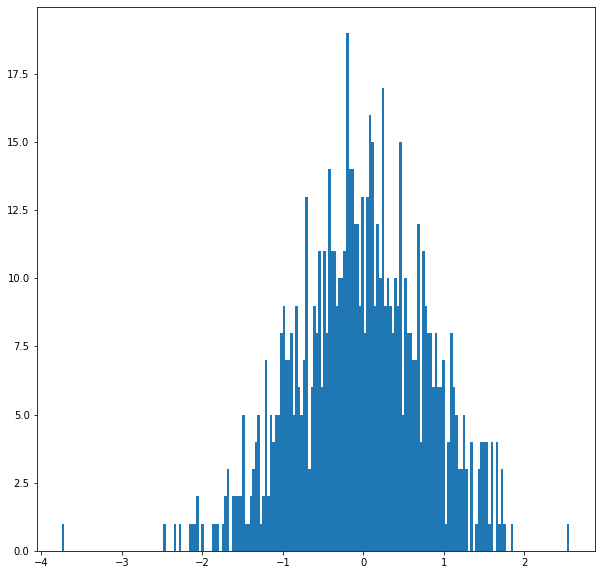

In [68]:
# For our token, select its feature values from layer 5.
token_i = 1
layer_i = 5
vec = encoded_layers[layer_i][batch_i][token_i]
# print(vec)

# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()

In [23]:
# `encoded_layers` is a Python list.
print('     Type of encoded_layers: ', type(encoded_layers))

# Each layer in the list is a torch tensor.
print('Tensor shape for each layer: ', encoded_layers[0].size())

     Type of encoded_layers:  <class 'list'>
Tensor shape for each layer:  torch.Size([1, 3, 768])


In [24]:
# Concatenate the tensors for all layers. We use `stack` here to
# create a new dimension in the tensor.
token_embeddings = torch.stack(encoded_layers, dim=0)

token_embeddings.size()

torch.Size([12, 1, 3, 768])

In [25]:
# Remove dimension 1, the "batches".
token_embeddings = torch.squeeze(token_embeddings, dim=1)

token_embeddings.size()

torch.Size([12, 3, 768])

In [26]:
# Swap dimensions 0 and 1.
token_embeddings = token_embeddings.permute(1,0,2)

token_embeddings.size()

torch.Size([3, 12, 768])

In [72]:
# Concatenate the last 4 hidden layers to create word embeddings.
# Stores the token vectors, with shape [22 x 3,072]
token_vecs_cat = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:
    
    # `token` is a [12 x 768] tensor

    # Concatenate the vectors (that is, append them together) from the last 
    # four layers.
    # Each layer vector is 768 values, so `cat_vec` is length 3,072.
    cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
    
    # Use `cat_vec` to represent `token`.
    token_vecs_cat.append(cat_vec)

print ('Shape is: %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0])))
print(token_vecs_cat[0])

Shape is: 3 x 3072
tensor([-0.0637,  0.3612, -0.0899,  ..., -0.4850, -0.3801,  0.8791])


In [29]:
# Sum the last 4 hidden layers to create word embeddings.
# Stores the token vectors, with shape [22 x 768]
token_vecs_sum = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

    # `token` is a [12 x 768] tensor

    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(token[-4:], dim=0)
    
    # Use `sum_vec` to represent `token`.
    token_vecs_sum.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

Shape is: 3 x 768


In [30]:
# Concatenate the last 4 hidden layers to create word embeddings.
# Stores the token vectors, with shape [22 x 3,072]
token_vecs_cat_first = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:
    
    # `token` is a [12 x 768] tensor

    # Concatenate the vectors (that is, append them together) from the last 
    # four layers.
    # Each layer vector is 768 values, so `cat_vec` is length 3,072.
    cat_vec = torch.cat((token[0], token[1], token[2], token[3]), dim=0)
    
    # Use `cat_vec` to represent `token`.
    token_vecs_cat_first.append(cat_vec)

print ('Shape is: %d x %d' % (len(token_vecs_cat_first), len(token_vecs_cat_first[0])))
print(token_vecs_cat[0])

Shape is: 3 x 3072
tensor([-0.0637,  0.3612, -0.0899,  ..., -0.4850, -0.3801,  0.8791])


In [31]:
# Sum the last 4 hidden layers to create word embeddings.
# Stores the token vectors, with shape [22 x 768]
token_vecs_sum_first = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

    # `token` is a [12 x 768] tensor

    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(token[:4], dim=0)
    
    # Use `sum_vec` to represent `token`.
    token_vecs_sum_first.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum_first), len(token_vecs_sum_first[0])))

Shape is: 3 x 768


In [32]:
# Concatenate the last 4 hidden layers to create word embeddings.
# Stores the token vectors, with shape [22 x 3,072]
token_vecs_cat_middle1 = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:
    
    # `token` is a [12 x 768] tensor

    # Concatenate the vectors (that is, append them together) from the last 
    # four layers.
    # Each layer vector is 768 values, so `cat_vec` is length 3,072.
    cat_vec = torch.cat((token[4], token[5], token[6], token[7]), dim=0)
    
    # Use `cat_vec` to represent `token`.
    token_vecs_cat_middle1.append(cat_vec)

print ('Shape is: %d x %d' % (len(token_vecs_cat_middle1), len(token_vecs_cat_middle1[0])))
print(token_vecs_cat[0])

Shape is: 3 x 3072
tensor([-0.0637,  0.3612, -0.0899,  ..., -0.4850, -0.3801,  0.8791])


In [33]:
# Sum the last 4 hidden layers to create word embeddings.
# Stores the token vectors, with shape [22 x 768]
token_vecs_sum_middle1 = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

    # `token` is a [12 x 768] tensor

    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(token[4:8], dim=0)
    
    # Use `sum_vec` to represent `token`.
    token_vecs_sum_middle1.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum_middle1), len(token_vecs_sum_middle1[0])))

Shape is: 3 x 768


In [34]:
# Concatenate the last 4 hidden layers to create word embeddings.
# Stores the token vectors, with shape [22 x 3,072]
token_vecs_cat_middle2 = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:
    
    # `token` is a [12 x 768] tensor

    # Concatenate the vectors (that is, append them together) from the last 
    # four layers.
    # Each layer vector is 768 values, so `cat_vec` is length 3,072.
    cat_vec = torch.cat((token[8], token[9], token[10], token[11]), dim=0)
    
    # Use `cat_vec` to represent `token`.
    token_vecs_cat_middle2.append(cat_vec)

print ('Shape is: %d x %d' % (len(token_vecs_cat_middle2), len(token_vecs_cat_middle2[0])))
print(token_vecs_cat[0])

Shape is: 3 x 3072
tensor([-0.0637,  0.3612, -0.0899,  ..., -0.4850, -0.3801,  0.8791])


In [35]:
# Sum the last 4 hidden layers to create word embeddings.
# Stores the token vectors, with shape [22 x 768]
token_vecs_sum_middle2 = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

    # `token` is a [12 x 768] tensor

    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(token[8:], dim=0)
    
    # Use `sum_vec` to represent `token`.
    token_vecs_sum_middle2.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum_middle2), len(token_vecs_sum_middle2[0])))

Shape is: 3 x 768


In [36]:
# Concatenate the last 4 hidden layers to create word embeddings.
# Stores the token vectors, with shape [22 x 3,072]
token_vecs_cat_all = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:
    
    # `token` is a [12 x 768] tensor

    # Concatenate the vectors (that is, append them together) from the last 
    # four layers.
    # Each layer vector is 768 values, so `cat_vec` is length 3,072.
    cat_vec = torch.cat((token[0], token[1], token[2], token[3], token[4], token[5], token[6], token[7], token[8], token[9], token[10], token[11]), dim=0)
    
    # Use `cat_vec` to represent `token`.
    token_vecs_cat_all.append(cat_vec)

print ('Shape is: %d x %d' % (len(token_vecs_cat_all), len(token_vecs_cat_all[0])))
print(token_vecs_cat[0])

Shape is: 3 x 9216
tensor([-0.0637,  0.3612, -0.0899,  ..., -0.4850, -0.3801,  0.8791])


In [37]:
# Sum the last 4 hidden layers to create word embeddings.
# Stores the token vectors, with shape [22 x 768]
token_vecs_sum_all = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

    # `token` is a [12 x 768] tensor

    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(token[:], dim=0)
    
    # Use `sum_vec` to represent `token`.
    token_vecs_sum_all.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum_all), len(token_vecs_sum_all[0])))

Shape is: 3 x 768


In [38]:
# Make a single vector to represent the pair of sentences by averaging across tokens.
# `encoded_layers` has shape [12 x 1 x 22 x 768]
sentences_vec = []
# `token_vecs` is a tensor with shape [22 x 768]
token_vecs = encoded_layers[11][0]

# Calculate the average of all 22 token vectors.
sentence_embedding = torch.mean(token_vecs, dim=0)
for s in sentence_embedding:
    sentences_vec.append(s)
print ("Our final sentence embedding vector of shape:", sentence_embedding.size())
print(sentence_embedding[767])
print(sentence_embedding[-1])
print(f'Shape of sentences vector is: {len(sentences_vec)}')
print(sentences_vec[-1])

Our final sentence embedding vector of shape: torch.Size([768])
tensor(-0.1680)
tensor(-0.1680)
Shape of sentences vector is: 768
tensor(-0.1680)


In [ ]:
--------------------------------------------------------------------------------------
BEGIN TESTING STATIC CONTEXTUAL EMBEDDING CREATION
--------------------------------------------------------------------------------------

In [100]:
def make_vocab(vocab_file):
    # start = timer()
    vocab = []
    # vocab_file = '/home/jupyter/Notebooks/crystal/NLP/MiFace/Python/vocab_files/vocab_checked.txt'
    with open(vocab_file, 'r') as v:
        vocab = v.read().splitlines()
    # end = timer()
    # run_time = end - start
#     print(f'There are {len(vocab)} words in the vocabulary.\n')
#     print(f'It took {run_time} seconds to read the vocabulary file into memory.')
#     print(f'Test word is {vocab[2]}.')
    return vocab

In [75]:
def tokenize_text(vocab):
    tokenized_text = []
    indexed_tokens = []
    for word in vocab:
        # Add the special tokens.
    #     marked_text = "[CLS] " + word + " [SEP]"
        marked_text = word

        # Split the sentence into tokens.
        # tokenized_text = tokenizer.tokenize(marked_text)
        tokenized_text.append(tokenizer.tokenize(marked_text))
#         print(f'Added {tokenized_text[-1]} to the tokenized_text array.')


        # Map the token strings to their vocabulary indeces.
        indexed_tokens.append(tokenizer.convert_tokens_to_ids(tokenized_text[-1]))

        # Display the words with their indeces.
    #     print(f'The word {tokenized_text[-1][1]} is at index {indexed_tokens[-1]}.')
#         for tup in zip(tokenized_text[-1], indexed_tokens[-1]):
#             print('{:<12} {:>6,}'.format(tup[0], tup[1]))
    return tokenized_text, indexed_tokens

In [95]:
# Recreate vocabulary words from their tokenized representations.
for t in tokenized_text:
    this_word = ''
    for token in t:
        this_word += token.strip('#')
#     print(this_word)

In [98]:
def generate_segments_IDs(tokenized_text):
    # Create segment IDs for sentence 1 (there can be a sentence 0 to compare to
    # sentence 1, but we're not doing that).
    # Check that indices and token indices look correct.
    segments_IDs = []
    for i in range(len(tokenized_text)):
        segments_IDs.append([1] * len(tokenized_text[i]))
#     for i in range(len(segments_IDs)):
#         print (segments_IDs[i])
#         print(tokenized_text[i])
    return segments_IDs

In [152]:
# Ok, let's start putting this all together.
############################################

# Set up input and output paths.
vocab_file = '/home/jupyter/Notebooks/crystal/NLP/MiFace/Python/vocab_files/vocab_checked.txt'
embeddings_file = '/home/jupyter/Notebooks/crystal/NLP/nlp_testing/vocabulary_embeddings/BERT.txt'
if os.path.exists(embeddings_file):
    os.remove(embeddings_file)

# Create a list of vocabulary words we want embeddings for.
vocab = make_vocab(vocab_file)

# Tokenize the vocabulary and look up the BERT token indices.
tokenized_text, indexed_tokens = tokenize_text(vocab)

# Generate segment IDs for each token.
segments_IDs = generate_segments_IDs(tokenized_text)

# Generate and write out the contextual embeddings for the vocabulary words.
# Embeddings are saved in a standard format that can be used for calcualting
# the cosine distances between word vectors.
for i in range(len(tokenized_text)):
    # Convert indexed tokens and segments to tensors.
    # Create a BERT model for the tokens.
    # Get the encoded model layers and reshape them.
    token_embeddings = generate_embeddings(indexed_tokens[i], segments_IDs[i])
    print(f'{tokenized_text[i]} has a token embedding of size {token_embeddings.size()}')
    
    # Extract the contextual embedding for a token.
    contextual_embedding = cat_last_four(token_embeddings)
    
    # Write the embedding to a text file, with the vocabulary word prepended.
    vocab_word = reconstruct_tokens(tokenized_text[i])
    # Make sure we've got the correct vocabulary word.
    assert vocab[i] == vocab_word
    write_embedding(embeddings_file, vocab[i], contextual_embedding)

['aback'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.2373,  0.8259, -0.6190,  ..., -0.3836, -0.5039,  0.6153])
aback
Saved the embedding for aback.
['aba', '##shed'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([-0.1037, -0.2061,  0.1823,  ..., -0.5667, -1.2614,  0.1785])
abashed
Saved the embedding for abashed.
['ab', '##hor'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([-0.8100,  0.2958,  0.1761,  ..., -0.9277, -0.8062,  0.7046])
abhor
Saved the embedding for abhor.
['ab', '##hor', '##red'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 3072
tensor([-0.1539,  0.0500,  0.2618,  ..., -1.0918, -0.8056,  0.2805])
abhorred
Saved the embedding for abhorred.
['ab', '##hor', '##rence'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 3072
tensor([ 0.0112, -0.1689,  0.0145,  ..., -1.3856, -0.4802,  0.5721])
abhorrence
Saved the embedding 

['ag', '##gra', '##vation'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 3072
tensor([-0.4945,  0.4427, -0.4905,  ...,  0.3184, -0.1085,  0.4077])
aggravation
Saved the embedding for aggravation.
['aggression'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.0964, -0.3315, -0.4422,  ..., -0.7226, -0.8147,  0.6407])
aggression
Saved the embedding for aggression.
['aggressive'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([ 0.1769, -0.2582, -0.0493,  ...,  0.1390, -0.6079,  0.6387])
aggressive
Saved the embedding for aggressive.
['ag', '##gr', '##ie', '##ve'] has a token embedding of size torch.Size([4, 12, 768])
Shape is: 4 x 3072
tensor([-0.4852, -0.0223,  0.2060,  ..., -0.7569, -0.1021,  0.4570])
aggrieve
Saved the embedding for aggrieve.
['ag', '##gr', '##ie', '##ved'] has a token embedding of size torch.Size([4, 12, 768])
Shape is: 4 x 3072
tensor([-0.8501, -0.0982,  0.5716,  ..., -1.726

['ang', '##st'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([-0.4853,  0.1324,  0.4863,  ..., -0.7058, -0.4154,  0.3137])
angst
Saved the embedding for angst.
['anguish'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.2006,  0.2713, -0.4094,  ..., -0.7437,  0.3730, -0.2416])
anguish
Saved the embedding for anguish.
['anguish', '##ed'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([-0.2117,  0.0008, -0.4303,  ..., -0.7570, -0.0793, -0.3513])
anguished
Saved the embedding for anguished.
['animated'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([ 0.0165,  0.4059,  0.2465,  ..., -0.1559, -0.0591,  0.7104])
animated
Saved the embedding for animated.
['an', '##imo', '##sity'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 3072
tensor([ 1.0127,  1.1249,  0.7201,  ..., -1.0992, -0.5671,  0.9526])
animosity
Saved the embedding fo

['ashamed'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.5104,  0.4469, -0.3548,  ..., -0.0204, -0.7246,  0.7084])
ashamed
Saved the embedding for ashamed.
['aspiring'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.7016, -0.0617, -1.1961,  ..., -0.2038, -1.0683,  1.2431])
aspiring
Saved the embedding for aspiring.
['assert', '##ive'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([-0.5499, -0.0697, -0.8019,  ..., -0.6104, -0.8485,  0.4657])
assertive
Saved the embedding for assertive.
['assert', '##ively'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([-0.4839,  0.8503, -0.5544,  ..., -0.8873,  0.2028, -0.2159])
assertively
Saved the embedding for assertively.
['assessing'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-1.0186,  0.1184, -0.3297,  ..., -0.7483, -0.5208,  1.1083])
assessing
Saved the embedd

['beat'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.3186, -0.3382,  0.0280,  ..., -0.2010, -0.0573,  1.0928])
beat
Saved the embedding for beat.
['beaten'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.2192,  0.2330,  0.3545,  ..., -0.1227, -0.0687, -0.0435])
beaten
Saved the embedding for beaten.
['bed', '##ev', '##iled'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 3072
tensor([-0.1200,  0.0374,  0.4366,  ..., -0.4766, -0.3909,  0.0325])
bedeviled
Saved the embedding for bedeviled.
['be', '##fu', '##ddled'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 3072
tensor([ 0.4222, -0.2418,  0.4857,  ..., -1.1165, -0.8866, -0.1426])
befuddled
Saved the embedding for befuddled.
['begging'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.0286,  0.4366, -0.0744,  ..., -0.1301, -0.3846,  0.3227])
begging
Saved the embedding for beggi

['bleak'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([ 0.1330,  0.1329, -0.3797,  ..., -0.9772, -0.2545,  0.5260])
bleak
Saved the embedding for bleak.
['b', '##lea', '##ry'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 3072
tensor([-0.1147, -0.0241, -0.4997,  ..., -0.7672, -1.3000,  0.3609])
bleary
Saved the embedding for bleary.
['blessed'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.5280,  0.5087,  0.0342,  ..., -0.5946, -0.2725,  0.7242])
blessed
Saved the embedding for blessed.
['blew'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.4337, -0.1070, -0.2291,  ..., -0.4218, -0.5849,  0.3551])
blew
Saved the embedding for blew.
['blinded'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([ 0.2770, -0.2773, -0.1820,  ...,  0.2322, -0.0723,  0.9322])
blinded
Saved the embedding for blinded.
['blinds', '##ided'] has a

['bully'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([ 0.6595,  0.3447,  0.3987,  ...,  0.4893, -0.7898, -0.0581])
bully
Saved the embedding for bully.
['bullying'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-1.2629,  0.1817,  0.8786,  ...,  0.4557, -0.3481, -0.3209])
bullying
Saved the embedding for bullying.
['bum', '##med'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([-0.1493,  0.0150,  0.4361,  ..., -0.5599, -0.3190,  0.7930])
bummed
Saved the embedding for bummed.
['bu', '##oya', '##nt'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 3072
tensor([-0.4209, -0.1897,  0.3018,  ..., -1.4227, -0.4613,  0.5842])
buoyant
Saved the embedding for buoyant.
['burden', '##ed'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([ 0.0419, -0.2074, -0.4295,  ..., -0.6852, -0.2515,  0.2873])
burdened
Saved the embedding for burdened.

['challenged'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.8241,  0.6032,  0.7930,  ..., -0.6740, -0.3437,  1.2468])
challenged
Saved the embedding for challenged.
['challenging'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.7438, -0.3002, -0.2622,  ..., -0.4557, -0.1921,  0.8395])
challenging
Saved the embedding for challenging.
['chaotic'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([ 0.3295, -0.1395,  0.0214,  ..., -0.9724, -0.1039,  0.7766])
chaotic
Saved the embedding for chaotic.
['charged'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.4290,  0.2998, -0.0408,  ...,  0.1488,  0.2866,  0.5824])
charged
Saved the embedding for charged.
['charm', '##ed'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([-0.0690, -0.1625,  0.6502,  ..., -1.1069, -0.1206, -0.2439])
charmed
Saved the embedding for ch

['clue', '##less'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([-0.4185,  0.3037,  0.1674,  ..., -0.6846, -0.1050,  0.9772])
clueless
Saved the embedding for clueless.
['clutched'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.1055,  0.6900,  0.2380,  ..., -0.4523, -0.6954,  0.7763])
clutched
Saved the embedding for clutched.
['cl', '##uttered'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([-0.1100,  0.1295, -0.0494,  ..., -0.9315, -0.3524,  0.2269])
cluttered
Saved the embedding for cluttered.
['cock', '##eye', '##d'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 3072
tensor([-0.2250,  0.3780,  0.0018,  ..., -0.5734, -0.6652, -0.1029])
cockeyed
Saved the embedding for cockeyed.
['cock', '##iness'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([-1.0098, -0.0118, -0.1453,  ..., -0.9219, -0.8229,  1.2585])
cockiness
Save

['concentration'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([ 0.0359,  0.2681, -0.2709,  ..., -0.8553,  0.1728,  1.2216])
concentration
Saved the embedding for concentration.
['concern'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.4547,  0.3462,  0.2862,  ..., -0.2359, -0.5249,  0.4341])
concern
Saved the embedding for concern.
['concerned'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.3273,  0.2658,  0.4718,  ...,  0.3076, -0.5044,  0.2820])
concerned
Saved the embedding for concerned.
['con', '##ci', '##lia', '##tory'] has a token embedding of size torch.Size([4, 12, 768])
Shape is: 4 x 3072
tensor([-0.0198, -0.2473,  0.3366,  ..., -0.3022, -0.3590,  0.8848])
conciliatory
Saved the embedding for conciliatory.
['con', '##clusive'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([-0.2490, -0.1562, -0.1391,  ..., -0.0278, -0.7220,  1.19

['content'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.0144,  1.0302,  0.1368,  ..., -0.3608,  0.3433,  0.9893])
content
Saved the embedding for content.
['content', '##ed'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([-0.5165,  0.6496,  0.2588,  ..., -0.3828,  0.0771,  0.8645])
contented
Saved the embedding for contented.
['contentious'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.1609,  0.1812,  0.1119,  ..., -0.2186, -0.9244, -0.3554])
contentious
Saved the embedding for contentious.
['content', '##ly'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([-0.1764,  0.8661,  0.0397,  ..., -1.1885, -0.2975,  0.7752])
contently
Saved the embedding for contently.
['content', '##ment'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([-0.1212,  0.6930,  0.1077,  ..., -0.6260,  0.1187,  0.7944])
contentment
Sav

['curiosity'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.4938,  0.1625, -0.0689,  ..., -0.4770, -0.8498,  0.7550])
curiosity
Saved the embedding for curiosity.
['curious'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([ 0.3554,  0.1518, -0.5690,  ..., -1.2279,  0.1953,  0.1932])
curious
Saved the embedding for curious.
['cutting'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.5108,  0.6118,  0.3939,  ...,  0.6303, -0.3443,  0.8765])
cutting
Saved the embedding for cutting.
['cy', '##nic'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([ 0.0311, -0.2899,  0.1165,  ..., -0.5906,  0.2950,  0.7172])
cynic
Saved the embedding for cynic.
['cynical'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.0111, -0.0900,  0.7567,  ..., -0.9884,  0.0257,  0.0450])
cynical
Saved the embedding for cynical.
['cy', '##nic'

['del', '##ibe', '##rating'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 3072
tensor([ 0.1196, -0.1439,  0.4765,  ..., -1.1946, -0.3878,  0.5008])
deliberating
Saved the embedding for deliberating.
['delight'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.0058, -0.1501, -0.7442,  ..., -0.2575, -0.2765,  1.2016])
delight
Saved the embedding for delight.
['delighted'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.7438,  0.2008, -0.0937,  ..., -0.1465, -0.7249,  0.9160])
delighted
Saved the embedding for delighted.
['delightful'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.3387,  0.5431,  0.2850,  ..., -0.7200, -0.2394,  1.1215])
delightful
Saved the embedding for delightful.
['del', '##iri', '##ous'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 3072
tensor([ 0.3813, -0.0087,  0.8099,  ..., -1.4150, -0.1262,  0.2830])
delir

['determination'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.5277,  0.1303,  0.0709,  ..., -1.1588, -0.0573,  0.6104])
determination
Saved the embedding for determination.
['determined'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.7999,  0.0562,  0.2695,  ..., -1.5268, -0.5233,  0.4093])
determined
Saved the embedding for determined.
['determining'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.2708,  0.3253,  0.6310,  ..., -1.0668, -0.1971,  0.7289])
determining
Saved the embedding for determining.
['deter', '##red'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([-0.1352,  0.3341, -0.3183,  ..., -1.1441, -0.4603,  1.1193])
deterred
Saved the embedding for deterred.
['det', '##est'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([-0.6483,  0.3771,  0.0533,  ..., -0.2097, -0.3880,  1.1985])
detest
S

['discount', '##ed'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([-0.2474,  0.3807,  0.2794,  ..., -0.6461, -0.8495,  0.1587])
discounted
Saved the embedding for discounted.
['discouraged'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.9798, -0.0387, -0.3839,  ..., -0.2456, -0.1778,  0.1200])
discouraged
Saved the embedding for discouraged.
['discovery'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.5146,  0.7006, -1.6729,  ..., -0.2180, -0.9743,  0.9419])
discovery
Saved the embedding for discovery.
['disc', '##rim', '##inating'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 3072
tensor([-0.1541,  0.4210, -0.1649,  ..., -0.8608,  0.0293,  0.7341])
discriminating
Saved the embedding for discriminating.
['discussed'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.5883, -0.2621, -0.6074,  ..., -0.1763, -0.5054,  0.

['di', '##sp', '##ass', '##ion', '##ate'] has a token embedding of size torch.Size([5, 12, 768])
Shape is: 5 x 3072
tensor([ 0.0596,  0.0333,  0.3343,  ..., -0.2350, -0.5530,  1.0503])
dispassionate
Saved the embedding for dispassionate.
['di', '##sp', '##iri', '##ted'] has a token embedding of size torch.Size([4, 12, 768])
Shape is: 4 x 3072
tensor([ 0.4413,  0.2158,  0.1771,  ..., -1.0111, -0.2633,  0.5836])
dispirited
Saved the embedding for dispirited.
['di', '##sp', '##iri', '##ted', '##ness'] has a token embedding of size torch.Size([5, 12, 768])
Shape is: 5 x 3072
tensor([ 0.0195,  0.2064,  0.4503,  ..., -0.9635, -0.5029,  1.0136])
dispiritedness
Saved the embedding for dispiritedness.
['di', '##sp', '##lea', '##sed'] has a token embedding of size torch.Size([4, 12, 768])
Shape is: 4 x 3072
tensor([-0.2945,  0.2486,  0.4643,  ..., -0.6296, -0.5571,  0.3090])
displeased
Saved the embedding for displeased.
['displeasure'] has a token embedding of size torch.Size([1, 12, 768])
Shap

['do', '##pe', '##y'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 3072
tensor([-0.1216,  0.0201,  0.4791,  ..., -0.7771, -0.5114,  0.5879])
dopey
Saved the embedding for dopey.
['dot', '##ing'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([-0.5013,  0.3559,  0.1688,  ..., -0.7846, -0.4168,  0.4394])
doting
Saved the embedding for doting.
['doubt'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.6620,  0.0766, -0.4501,  ..., -0.5562, -0.5247,  0.9385])
doubt
Saved the embedding for doubt.
['doubt', '##er'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([-0.9739,  0.1895,  0.3065,  ..., -1.7678, -0.7102,  0.3351])
doubter
Saved the embedding for doubter.
['doubtful'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.7239,  0.2190,  0.3856,  ...,  0.6220,  0.0622,  0.5666])
doubtful
Saved the embedding for doubtful.
['doubtf

['eager'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.7447,  0.3635, -0.0973,  ..., -0.2444, -0.6533,  0.6821])
eager
Saved the embedding for eager.
['eager', '##ness'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([-0.2682, -0.1884,  0.3436,  ..., -1.3241, -1.0432,  0.5539])
eagerness
Saved the embedding for eagerness.
['earnest'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.1067,  0.8266, -0.1909,  ..., -0.3778, -0.2373,  0.6131])
earnest
Saved the embedding for earnest.
['easy'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-1.0998, -0.1373,  0.0540,  ..., -0.4992, -0.2945,  1.0946])
easy
Saved the embedding for easy.
['e', '##bu', '##llie', '##nt'] has a token embedding of size torch.Size([4, 12, 768])
Shape is: 4 x 3072
tensor([ 0.1434, -0.4436,  0.3145,  ..., -0.8885, -0.0690,  0.4227])
ebullient
Saved the embedding for ebullient.

['eng', '##ross', '##ed'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 3072
tensor([ 0.0447,  0.0895,  0.3867,  ..., -0.6730, -0.5970,  0.6993])
engrossed
Saved the embedding for engrossed.
['eng', '##ross', '##ment'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 3072
tensor([ 0.1742,  0.0809,  0.6218,  ..., -0.3994, -0.1664,  0.5180])
engrossment
Saved the embedding for engrossment.
['enigma', '##tic'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([-0.7408,  0.3173,  0.3340,  ..., -0.4366,  0.0684,  1.0859])
enigmatic
Saved the embedding for enigmatic.
['enjoy'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.5025, -0.4330, -0.7282,  ..., -1.2163, -0.6111, -0.1100])
enjoy
Saved the embedding for enjoy.
['enjoying'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.0929, -0.1049, -0.2362,  ..., -0.3176,  0.0529,  0.2173])
enjoying
Sav

['exhausted'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.7753, -0.1664,  0.0757,  ..., -0.1676, -0.2345,  0.2690])
exhausted
Saved the embedding for exhausted.
['exhaustion'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.0899, -0.1988,  0.4548,  ..., -0.2376, -0.3880,  0.4954])
exhaustion
Saved the embedding for exhaustion.
['exhaust', '##ive'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([-0.2403,  0.3467, -0.8611,  ..., -1.0334, -0.1391, -0.1851])
exhaustive
Saved the embedding for exhaustive.
['ex', '##hila', '##rated'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 3072
tensor([-0.3065, -0.0822,  0.6645,  ..., -0.7838, -0.4048,  1.0198])
exhilarated
Saved the embedding for exhilarated.
['ex', '##hila', '##ration'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 3072
tensor([ 0.1358,  0.2968,  0.8404,  ..., -0.5665, -0.0335, 

['feared'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.2138,  0.2448,  0.1420,  ..., -0.2256, -0.4298,  0.4798])
feared
Saved the embedding for feared.
['fearful'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.3182,  0.2606,  0.1425,  ...,  0.0569, -0.7185,  0.6242])
fearful
Saved the embedding for fearful.
['fearing'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.7887, -0.1608,  0.2378,  ..., -0.1686, -0.8443,  0.5267])
fearing
Saved the embedding for fearing.
['fearless'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.5275,  0.0648,  0.3288,  ..., -0.2955, -0.1152,  1.3940])
fearless
Saved the embedding for fearless.
['fears', '##ome'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([-0.7531, -0.0254, -0.2800,  ..., -0.9584, -0.0227,  0.2011])
fearsome
Saved the embedding for fearsome.
['fe', '##c

['foolish'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.8697,  0.1007, -0.3405,  ..., -0.2949, -0.4155,  0.1539])
foolish
Saved the embedding for foolish.
['for', '##be', '##aring'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 3072
tensor([-0.6186, -0.1353, -0.1487,  ..., -1.2539, -1.0153,  0.4311])
forbearing
Saved the embedding for forbearing.
['forbid', '##ding'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([-0.2774,  0.2188, -0.6364,  ..., -0.9882, -0.9320,  1.7266])
forbidding
Saved the embedding for forbidding.
['forced'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.8268, -0.1040,  0.0793,  ..., -0.6851, -0.0321,  0.6411])
forced
Saved the embedding for forced.
['forceful'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-1.1685, -0.0372,  0.3909,  ..., -0.2236, -1.0045,  0.5199])
forceful
Saved the embeddin

['furrowed'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.2885, -0.1027, -0.8260,  ..., -1.1436, -0.7611,  0.4820])
furrowed
Saved the embedding for furrowed.
['fur', '##tive'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([ 0.7148,  0.2684,  0.0219,  ..., -1.4458,  0.1558, -0.0697])
furtive
Saved the embedding for furtive.
['fury'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([ 0.0352,  0.5454, -0.1849,  ...,  0.1319,  0.1167,  0.8818])
fury
Saved the embedding for fury.
['fuss', '##y'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([ 0.2567,  0.6379,  0.4090,  ..., -1.1672, -1.0913,  0.8692])
fussy
Saved the embedding for fussy.
['gall', '##ed'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([-0.2030,  0.5232,  0.2319,  ..., -0.4234, -0.9317,  1.1945])
galled
Saved the embedding for galled.
['gall', '##ing']

['grateful'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.5022,  0.4182, -0.4831,  ..., -0.0115, -0.8259,  0.8416])
grateful
Saved the embedding for grateful.
['gr', '##ati', '##fied'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 3072
tensor([-0.4359,  0.6724, -0.0244,  ..., -1.1149, -0.8809, -0.0747])
gratified
Saved the embedding for gratified.
['grave'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.6232,  0.5123, -0.0072,  ..., -0.3325, -0.3811,  1.0601])
grave
Saved the embedding for grave.
['great'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([ 0.4622,  0.1038,  0.4184,  ..., -0.5856, -0.4574,  0.9020])
great
Saved the embedding for great.
['greedy'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.2199,  0.4779,  0.5174,  ...,  0.2076, -0.2171,  0.7245])
greedy
Saved the embedding for greedy.
['greeting'] h

['hate'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([ 0.3394,  0.4363, -0.5413,  ..., -0.2870, -0.7168,  0.7548])
hate
Saved the embedding for hate.
['hate', '##ful'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([-0.2053,  0.2865, -1.0713,  ..., -1.5166, -1.0215,  0.6680])
hateful
Saved the embedding for hateful.
['hating'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.1032, -0.2039, -0.4158,  ...,  0.0612, -0.3207,  0.2676])
hating
Saved the embedding for hating.
['hatred'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([ 0.2230,  0.1313,  0.3002,  ..., -0.0800, -0.0774,  0.6289])
hatred
Saved the embedding for hatred.
['ha', '##ught', '##y'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 3072
tensor([ 0.1082,  0.1185,  0.1647,  ..., -0.8024, -0.4548,  0.5661])
haughty
Saved the embedding for haughty.
['haunted'] has a

['hot'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([ 0.4349,  0.3011, -0.0699,  ..., -0.2523,  0.8104,  0.5346])
hot
Saved the embedding for hot.
['hot', '##shot'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([-0.0010,  0.0103,  0.5407,  ..., -0.5853,  0.2748,  0.3654])
hotshot
Saved the embedding for hotshot.
['huff', '##iness'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([-0.5596,  0.1776,  0.7155,  ..., -2.0268, -0.8025,  1.1481])
huffiness
Saved the embedding for huffiness.
['huff', '##y'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([-0.2355,  0.1176,  0.7510,  ..., -1.6657, -0.2155,  0.1524])
huffy
Saved the embedding for huffy.
['humble'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.0083,  0.5441,  0.0163,  ..., -0.4888, -0.1667,  1.1343])
humble
Saved the embedding for humble.
['humble', '##d']

['imp', '##erson', '##al'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 3072
tensor([-0.1958,  0.6485, -0.0615,  ..., -1.1200, -0.0885,  0.2873])
impersonal
Saved the embedding for impersonal.
['imp', '##ert', '##inen', '##t'] has a token embedding of size torch.Size([4, 12, 768])
Shape is: 4 x 3072
tensor([ 0.1635,  0.4252,  0.0590,  ..., -1.1000, -0.6604,  0.4328])
impertinent
Saved the embedding for impertinent.
['imp', '##ish'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([ 0.3715,  0.2431, -0.0500,  ..., -0.1880, -0.2258,  0.4389])
impish
Saved the embedding for impish.
['implicated'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([ 0.4407,  1.0302,  0.0541,  ..., -0.6504,  0.4436, -0.8402])
implicated
Saved the embedding for implicated.
['imp', '##lor', '##ing'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 3072
tensor([-0.3755,  0.1609,  0.0682,  ..., -0.5831, -0.

['informal'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.2913,  0.3932, -0.0062,  ..., -0.6487, -0.4704,  0.6802])
informal
Saved the embedding for informal.
['informing'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.1342,  0.3050,  0.2183,  ..., -0.6380, -0.0283,  1.0431])
informing
Saved the embedding for informing.
['in', '##fur', '##iated'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 3072
tensor([ 0.2672,  0.0948,  0.5369,  ..., -1.6159, -0.3431, -0.4073])
infuriated
Saved the embedding for infuriated.
['inhibit', '##ed'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([ 0.0575,  0.1748,  0.4186,  ..., -0.7092, -0.8851,  0.5557])
inhibited
Saved the embedding for inhibited.
['inhibit', '##ing'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([ 0.1361,  0.4376, -0.2181,  ..., -0.7936, -0.9982,  0.3004])
inhibiting

['interest'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([ 0.2857,  0.9341,  0.0094,  ...,  1.0435, -1.4215,  0.2650])
interest
Saved the embedding for interest.
['interested'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-1.0217,  0.1738, -0.0064,  ...,  0.1486, -0.8917,  0.2630])
interested
Saved the embedding for interested.
['inter', '##ject', '##ing'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 3072
tensor([-0.3561,  0.6730, -0.3851,  ..., -1.0079, -0.3626,  0.4907])
interjecting
Saved the embedding for interjecting.
['internal', '##izing'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([ 0.3777, -0.2325, -0.5848,  ..., -1.7891, -0.7915,  0.1164])
internalizing
Saved the embedding for internalizing.
['inter', '##ro', '##gating'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 3072
tensor([-0.7628,  0.3130,  0.5529,  ..., -0.4936,

['je', '##ering'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([-0.1824,  0.0605,  0.7671,  ..., -0.1669,  0.3013,  1.0647])
jeering
Saved the embedding for jeering.
['je', '##sti', '##ng'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 3072
tensor([-0.7154, -0.1673,  0.7047,  ..., -0.1661,  0.2801,  0.8534])
jesting
Saved the embedding for jesting.
['ji', '##lt', '##ed'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 3072
tensor([-0.1632, -0.2642, -0.0867,  ..., -0.9411, -0.7607,  0.6287])
jilted
Saved the embedding for jilted.
['ji', '##tter', '##y'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 3072
tensor([-0.5089, -0.7494,  0.2818,  ..., -0.4690, -0.2271,  0.4066])
jittery
Saved the embedding for jittery.
['jo', '##cular'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([ 0.6915, -0.1640,  0.4883,  ..., -0.9272, -0.3619,  0.5252])
jocular
Saved th

['lazy'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([ 0.1821,  0.1966,  0.2812,  ..., -0.6098, -0.2982,  1.6816])
lazy
Saved the embedding for lazy.
['leaving'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([ 0.1058,  0.7053,  0.9162,  ...,  0.6199, -1.1452,  0.7186])
leaving
Saved the embedding for leaving.
['le', '##cher', '##ous'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 3072
tensor([ 0.4690,  0.0844,  0.3000,  ..., -0.2985, -0.4230, -0.5602])
lecherous
Saved the embedding for lecherous.
['le', '##cturing'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([ 0.8027, -0.2914,  0.2028,  ..., -0.6003,  0.1568,  0.3498])
lecturing
Saved the embedding for lecturing.
['lee', '##ring'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([ 7.3443e-01,  6.2763e-02, -5.7687e-04,  ..., -4.2647e-01,
        -7.1802e-01,  6.7116e-01])
le

['mad'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.0935,  0.4282,  0.0942,  ..., -0.5294, -0.4106,  0.9301])
mad
Saved the embedding for mad.
['madden', '##ed'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([-0.4413,  0.4643, -0.0828,  ..., -0.9875, -0.2659,  0.5810])
maddened
Saved the embedding for maddened.
['madness'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.9105,  0.2989, -0.1886,  ..., -0.3715, -0.1946,  1.1728])
madness
Saved the embedding for madness.
['mal', '##con', '##ten', '##t'] has a token embedding of size torch.Size([4, 12, 768])
Shape is: 4 x 3072
tensor([-0.5006,  0.0948, -0.3374,  ..., -0.7847, -0.8597,  0.8710])
malcontent
Saved the embedding for malcontent.
['male', '##fi', '##cent'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 3072
tensor([-0.0771,  0.5633, -0.1300,  ..., -0.4981, -0.2581, -0.1806])
maleficent
Saved the e

['mis', '##lea', '##d'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 3072
tensor([-0.3478,  0.3054, -0.4359,  ..., -0.4106, -0.4373,  0.2348])
mislead
Saved the embedding for mislead.
['mist', '##rus', '##t'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 3072
tensor([-0.2375,  0.3757,  0.4033,  ..., -0.3974, -0.5730,  0.9491])
mistrust
Saved the embedding for mistrust.
['mist', '##rus', '##tf', '##ul'] has a token embedding of size torch.Size([4, 12, 768])
Shape is: 4 x 3072
tensor([-0.3653,  0.7298, -0.0356,  ..., -0.6777, -0.0251,  0.7922])
mistrustful
Saved the embedding for mistrustful.
['mist', '##rus', '##ting'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 3072
tensor([-0.0753,  0.7083, -0.0655,  ..., -0.6579, -0.6440,  0.9092])
mistrusting
Saved the embedding for mistrusting.
['misunderstood'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.0750, -0.7763,  0.1219,  ..., -0

['nausea', '##ted'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([-0.8126,  0.4214, -0.1264,  ..., -1.0022, -1.1475,  0.9848])
nauseated
Saved the embedding for nauseated.
['na', '##use', '##ous'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 3072
tensor([ 0.0077,  0.2344, -0.1280,  ..., -0.8803, -0.6440,  0.3850])
nauseous
Saved the embedding for nauseous.
['needy'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.8328, -0.0691, -0.2046,  ..., -0.9413, -0.3995,  0.9043])
needy
Saved the embedding for needy.
['ne', '##far', '##ious'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 3072
tensor([-0.0091,  0.1223, -0.2366,  ..., -1.4451, -0.0436, -0.0766])
nefarious
Saved the embedding for nefarious.
['ne', '##gating'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([-0.0636,  0.5150, -0.3440,  ..., -1.2718,  0.0495,  1.0054])
negating
Saved 

['observing'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([ 0.3263,  0.4065, -0.1258,  ...,  0.3603,  0.7308,  1.2928])
observing
Saved the embedding for observing.
['obsessed'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.8598, -0.0546, -0.8522,  ..., -0.1498,  0.1870,  0.3922])
obsessed
Saved the embedding for obsessed.
['ob', '##sti', '##nate'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 3072
tensor([-0.3175,  0.2508,  0.8939,  ..., -1.1821, -0.8580,  0.4210])
obstinate
Saved the embedding for obstinate.
['occupied'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.0343,  0.5047, -0.0849,  ..., -0.4386, -0.8039,  0.7781])
occupied
Saved the embedding for occupied.
['odd'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-4.3839e-01,  1.5015e-01,  8.2503e-01,  ..., -1.4842e-04,
         2.4503e-01,  1.2160e+00])
odd

['painful'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.4837, -0.1695, -0.0178,  ...,  0.2457, -0.1137,  0.5469])
painful
Saved the embedding for painful.
['painfully'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([ 0.4579,  0.0618, -0.9598,  ..., -0.8497,  0.2327, -0.0384])
painfully
Saved the embedding for painfully.
['panic'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([ 0.2360,  0.3185,  0.5303,  ..., -0.6194, -0.4005,  0.9618])
panic
Saved the embedding for panic.
['panicked'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([ 0.2622, -0.1153, -0.2336,  ..., -0.6881, -0.1797,  0.4474])
panicked
Saved the embedding for panicked.
['panic', '##ky'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([ 0.2257, -0.0790,  0.0373,  ..., -1.1440, -0.9711,  1.1754])
panicky
Saved the embedding for panicky.
['paralyzed

['pious'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-1.3112, -0.0655, -0.0640,  ..., -0.2799, -0.2690,  0.9496])
pious
Saved the embedding for pious.
['pi', '##que', '##d'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 3072
tensor([ 0.1132, -0.1045,  0.6886,  ..., -0.8137, -0.4007,  1.0927])
piqued
Saved the embedding for piqued.
['pissed'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-1.1945,  0.8221,  0.7383,  ..., -0.6379, -1.0105,  1.0869])
pissed
Saved the embedding for pissed.
['pit', '##iable'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([-0.0063, -0.0503, -0.4476,  ..., -0.9968, -0.4127,  0.0182])
pitiable
Saved the embedding for pitiable.
['pit', '##iful'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([-0.3846, -0.3973,  0.6675,  ..., -0.3502,  0.3726,  0.6205])
pitiful
Saved the embedding for pitiful.
['pit

['powerless'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.3880, -0.1413,  0.3404,  ..., -0.3945, -0.9578,  0.6648])
powerless
Saved the embedding for powerless.
['prank', '##ing'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([ 0.1221, -0.4078, -0.1814,  ..., -0.9495, -0.5797,  0.9363])
pranking
Saved the embedding for pranking.
['pre', '##car', '##ious'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 3072
tensor([ 0.4595,  0.1721,  0.3028,  ..., -0.8718, -1.1526,  0.5751])
precarious
Saved the embedding for precarious.
['predatory'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.0850,  0.3452,  0.5681,  ...,  0.3829, -0.3548,  0.6912])
predatory
Saved the embedding for predatory.
['prejudice', '##d'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([-0.2074,  0.1951,  0.0572,  ..., -0.1890, -0.7716,  0.7223])
prejudiced

['que', '##nched'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([ 0.2592, -0.5355, -0.1215,  ..., -0.2272, -0.4280,  0.7057])
quenched
Saved the embedding for quenched.
['questionable'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([ 0.7483,  0.7424, -0.3579,  ..., -0.8061, -0.6547,  0.3991])
questionable
Saved the embedding for questionable.
['questioning'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-1.2302,  0.5811, -0.8111,  ..., -1.2668,  0.0973, -0.1375])
questioning
Saved the embedding for questioning.
['questioning', '##ly'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([ 0.0182,  0.4103,  0.2639,  ..., -0.5783, -0.3167,  0.4856])
questioningly
Saved the embedding for questioningly.
['quiet'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([ 0.1685, -0.2009, -0.2039,  ..., -0.1685,  0.6079,  0.5533])
qui

['rejection'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.6658, -0.2614, -0.1085,  ...,  0.0263, -0.7778,  0.4756])
rejection
Saved the embedding for rejection.
['re', '##jo', '##icing'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 3072
tensor([-0.2852, -0.4755,  0.5381,  ..., -0.8061, -0.1296,  0.4822])
rejoicing
Saved the embedding for rejoicing.
['relaxation'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.1237,  0.0303, -0.3955,  ..., -0.2279,  0.1820,  1.2975])
relaxation
Saved the embedding for relaxation.
['relaxed'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([ 0.3671,  0.0751,  0.8969,  ..., -0.6867,  0.2165,  0.7741])
relaxed
Saved the embedding for relaxed.
['relentless'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.0059, -0.2149,  0.1908,  ..., -1.0624, -0.0298,  0.3763])
relentless
Saved the embe

['restraint'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-1.2845e-01, -1.3622e-03, -3.8630e-01,  ..., -3.8296e-01,
        -3.1033e-01,  1.5070e+00])
restraint
Saved the embedding for restraint.
['re', '##tal', '##iating'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 3072
tensor([ 0.6978,  0.4095,  0.0281,  ..., -1.0275, -0.7776, -0.1419])
retaliating
Saved the embedding for retaliating.
['re', '##tal', '##ia', '##tory'] has a token embedding of size torch.Size([4, 12, 768])
Shape is: 4 x 3072
tensor([ 0.6530, -0.0824,  0.0300,  ..., -1.1571, -0.1955,  0.3832])
retaliatory
Saved the embedding for retaliatory.
['re', '##thi', '##nk', '##ing'] has a token embedding of size torch.Size([4, 12, 768])
Shape is: 4 x 3072
tensor([ 0.2617, -0.1998,  0.2523,  ..., -0.7790, -0.1311,  0.1328])
rethinking
Saved the embedding for rethinking.
['re', '##tic', '##ence'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 30

['sas', '##sy'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([-0.5027,  0.0080,  0.1293,  ..., -0.5751, -0.3217,  0.3794])
sassy
Saved the embedding for sassy.
['sat', '##ed'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([-0.1860, -0.0608,  0.4885,  ..., -1.3793, -0.9776,  0.2635])
sated
Saved the embedding for sated.
['sat', '##iated'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([-0.0477,  0.5557,  0.3092,  ..., -1.1325, -0.3338, -0.0930])
satiated
Saved the embedding for satiated.
['satirical'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.2411, -0.8612,  0.1332,  ..., -0.8219,  0.9260, -0.5804])
satirical
Saved the embedding for satirical.
['satisfaction'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.4113, -0.0323,  0.2604,  ..., -0.4468,  0.2512, -0.1128])
satisfaction
Saved the embedding for sati

['seriousness'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.0174,  0.4382, -0.3134,  ..., -1.3854,  0.0078,  0.9109])
seriousness
Saved the embedding for seriousness.
['ser', '##vil', '##e'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 3072
tensor([-0.2733, -0.1113,  0.3387,  ..., -0.1339,  0.3114,  0.2793])
servile
Saved the embedding for servile.
['set'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.5269, -0.0413,  0.1660,  ...,  0.2931, -0.0346,  0.1625])
set
Saved the embedding for set.
['severe'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.7693, -0.2709, -0.4075,  ..., -0.1528, -0.3123,  0.4482])
severe
Saved the embedding for severe.
['sha', '##bby'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([-0.2621, -0.1788, -0.2191,  ..., -0.4177, -0.4560,  0.4112])
shabby
Saved the embedding for shabby.
['shady'

['sincere'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.1855,  0.4497,  0.1735,  ..., -0.0393, -0.1804,  0.9481])
sincere
Saved the embedding for sincere.
['sin', '##ful'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([ 0.4119,  0.2557,  0.2197,  ..., -1.0336, -0.0423,  0.3371])
sinful
Saved the embedding for sinful.
['singing'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.3853,  0.2555, -0.0112,  ..., -0.6633,  0.6852,  0.1082])
singing
Saved the embedding for singing.
['sinister'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.0748,  0.0248,  0.8027,  ..., -0.4077, -0.6662,  0.1496])
sinister
Saved the embedding for sinister.
['sinister', '##ly'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([-0.1589, -0.0696,  0.8148,  ..., -0.7665, -0.6535,  1.0098])
sinisterly
Saved the embedding for sinisterly.

['s', '##neer', '##ing'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 3072
tensor([-0.3907,  0.1769, -1.0123,  ..., -1.5974, -0.9630, -0.0072])
sneering
Saved the embedding for sneering.
['s', '##nee', '##ze'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 3072
tensor([-0.2045,  0.0846,  0.2003,  ..., -1.0348, -1.1238,  0.4171])
sneeze
Saved the embedding for sneeze.
['s', '##nee', '##zing'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 3072
tensor([ 0.4471,  0.0719, -0.3664,  ..., -1.1229, -0.8507, -0.0388])
sneezing
Saved the embedding for sneezing.
['s', '##nick', '##er'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 3072
tensor([ 0.4675,  0.1444, -0.0044,  ..., -0.7076, -0.6424,  0.6758])
snicker
Saved the embedding for snicker.
['s', '##nick', '##ering'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 3072
tensor([ 0.2632, -0.0064,  0.0172,  ..., -1.7584, -0.9909,  0.24

['sq', '##ue', '##ami', '##sh'] has a token embedding of size torch.Size([4, 12, 768])
Shape is: 4 x 3072
tensor([ 0.1067, -0.0082,  0.2986,  ..., -0.5967, -0.3106,  0.8903])
squeamish
Saved the embedding for squeamish.
['staggered'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.9806,  0.0551, -0.4051,  ...,  0.7531, -1.1780,  0.6578])
staggered
Saved the embedding for staggered.
['stalker'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-1.0074, -0.1041, -0.3790,  ..., -0.3580,  0.0116,  1.0811])
stalker
Saved the embedding for stalker.
['stare'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.5289,  0.0673,  0.8691,  ..., -0.6041, -0.6719,  0.4251])
stare
Saved the embedding for stare.
['staring'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.2930,  0.1672, -0.2115,  ..., -0.2238, -0.1107,  1.0636])
staring
Saved the embedding for stari

['stubborn', '##ness'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([ 1.1545e-04,  1.0183e-01,  6.9308e-01,  ..., -1.5619e+00,
        -4.5262e-01,  1.8042e+00])
stubbornness
Saved the embedding for stubbornness.
['studio', '##us'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([ 0.3301,  0.7584,  0.3448,  ...,  0.0123, -0.5465,  0.3770])
studious
Saved the embedding for studious.
['studying'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.1562,  0.2494,  0.0879,  ..., -0.2843, -0.3875,  0.5940])
studying
Saved the embedding for studying.
['stump', '##ed'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([-0.3548,  0.3448, -0.0608,  ..., -1.4218,  0.3414, -0.3655])
stumped
Saved the embedding for stumped.
['stung'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([ 0.0920,  0.2823,  0.1740,  ..., -0.4858,  0.0106,  0

['suspicious', '##ness'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([-0.1917, -0.0264, -0.2658,  ..., -0.6181, -0.4556,  0.9894])
suspiciousness
Saved the embedding for suspiciousness.
['sw', '##agger', '##ing'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 3072
tensor([-0.1718,  0.1579,  0.0109,  ..., -0.5895, -0.4809,  0.3978])
swaggering
Saved the embedding for swaggering.
['swearing'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([ 0.1839,  0.0138, -0.1400,  ...,  0.3850,  0.0816,  0.9346])
swearing
Saved the embedding for swearing.
['sympathetic'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.4848,  0.0181, -0.3224,  ..., -0.4505,  0.8966, -0.2290])
sympathetic
Saved the embedding for sympathetic.
['sy', '##mp', '##athi', '##zing'] has a token embedding of size torch.Size([4, 12, 768])
Shape is: 4 x 3072
tensor([ 0.5158, -0.0890,  0.5287,  ..., -0.

['thoughtful'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([ 0.3182, -0.3995, -0.4160,  ..., -0.4334, -0.7698,  0.8394])
thoughtful
Saved the embedding for thoughtful.
['thoughtful', '##ness'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([ 0.2649,  0.2980,  0.2432,  ..., -0.6108, -0.3470,  0.7709])
thoughtfulness
Saved the embedding for thoughtfulness.
['threat'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.2650,  0.2609, -0.0364,  ..., -0.5473, -0.6763,  0.3133])
threat
Saved the embedding for threat.
['threatened'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.2250,  0.3403, -0.7477,  ..., -0.2263, -0.6743,  0.8661])
threatened
Saved the embedding for threatened.
['threatening'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([ 0.0337, -0.5175,  0.3720,  ..., -0.8087, -0.5153,  0.4605])
threatening
Sav

['troubles', '##ome'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([-0.1222,  0.0161,  0.7258,  ..., -0.5508, -0.3833,  0.7535])
troublesome
Saved the embedding for troublesome.
['tr', '##ou', '##bling'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 3072
tensor([ 0.0821, -0.0253,  0.5277,  ..., -0.8612, -0.2728,  0.7732])
troubling
Saved the embedding for troubling.
['trusting'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-1.1427, -0.1326, -0.5030,  ..., -0.3338, -0.7645,  1.1659])
trusting
Saved the embedding for trusting.
['trust', '##worthy'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([-0.1769,  0.2195,  0.5270,  ..., -0.6275, -0.2921,  0.6891])
trustworthy
Saved the embedding for trustworthy.
['tu', '##mu', '##lt', '##uous'] has a token embedding of size torch.Size([4, 12, 768])
Shape is: 4 x 3072
tensor([ 0.1909,  0.2077, -0.4625,  ..., -0.8751, -0

['understanding'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.5560,  0.2281,  0.0907,  ..., -0.2438, -0.1638,  0.5212])
understanding
Saved the embedding for understanding.
['und', '##es', '##ira', '##ble'] has a token embedding of size torch.Size([4, 12, 768])
Shape is: 4 x 3072
tensor([ 0.0832,  0.4374,  0.2160,  ..., -0.8055, -0.3607,  0.1629])
undesirable
Saved the embedding for undesirable.
['unease'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.0998, -0.2231,  0.4580,  ..., -0.2564, -0.9567,  0.0647])
unease
Saved the embedding for unease.
['une', '##asi', '##ly'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 3072
tensor([-0.3279,  0.5232, -0.3926,  ..., -0.2564,  0.2068,  0.1616])
uneasily
Saved the embedding for uneasily.
['une', '##asi', '##ness'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 3072
tensor([-0.1741,  0.1321, -0.0291,  ..., -0.2099,  0.06

['un', '##sett', '##led'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 3072
tensor([-0.0261,  0.2647, -0.1026,  ..., -0.4464, -0.3748,  0.4496])
unsettled
Saved the embedding for unsettled.
['un', '##so', '##cia', '##ble'] has a token embedding of size torch.Size([4, 12, 768])
Shape is: 4 x 3072
tensor([-0.4759,  0.3809, -0.0773,  ..., -0.2787, -0.0619,  0.6059])
unsociable
Saved the embedding for unsociable.
['un', '##sp', '##eak', '##ing'] has a token embedding of size torch.Size([4, 12, 768])
Shape is: 4 x 3072
tensor([-0.1974,  0.2681, -0.1800,  ..., -0.3274, -0.2336,  0.0506])
unspeaking
Saved the embedding for unspeaking.
['unspoken'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([ 0.3609,  0.5245,  0.2508,  ..., -0.8474, -0.2840, -0.1567])
unspoken
Saved the embedding for unspoken.
['un', '##st', '##run', '##g'] has a token embedding of size torch.Size([4, 12, 768])
Shape is: 4 x 3072
tensor([-0.1195,  0.3059,  0.5138,  

['villain', '##ous'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([ 0.0359,  0.5067, -0.0634,  ..., -0.3968, -0.2144,  0.7419])
villainous
Saved the embedding for villainous.
['vin', '##dict', '##ive'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 3072
tensor([-0.0510, -0.1009,  0.3064,  ..., -0.6174, -0.6857,  0.8834])
vindictive
Saved the embedding for vindictive.
['violence'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.5859,  0.0607,  0.8000,  ..., -0.2548,  0.3317,  0.4190])
violence
Saved the embedding for violence.
['violent'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([ 0.4578,  0.0196, -0.6937,  ..., -1.6682,  0.4664, -0.7200])
violent
Saved the embedding for violent.
['viper', '##ous'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([-0.3890,  0.4372, -0.4146,  ..., -0.9046, -1.0771,  0.8666])
viperous
Saved 

['wired'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([-0.2667, -0.1433, -0.4547,  ..., -0.4209, -0.0263,  1.1327])
wired
Saved the embedding for wired.
['wish', '##ful'] has a token embedding of size torch.Size([2, 12, 768])
Shape is: 2 x 3072
tensor([-0.1382,  0.2580,  0.3462,  ..., -1.2650, -0.0182,  0.8658])
wishful
Saved the embedding for wishful.
['wi', '##st', '##ful'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 3072
tensor([-0.6485, -0.0527,  0.0858,  ..., -1.2290, -0.8816,  0.7261])
wistful
Saved the embedding for wistful.
['wi', '##st', '##fully'] has a token embedding of size torch.Size([3, 12, 768])
Shape is: 3 x 3072
tensor([-0.8708,  0.0314,  0.5018,  ..., -1.0104, -0.5930,  0.6682])
wistfully
Saved the embedding for wistfully.
['withdraw'] has a token embedding of size torch.Size([1, 12, 768])
Shape is: 1 x 3072
tensor([ 0.1297,  0.1923,  0.0261,  ...,  0.0216, -0.3791,  0.3518])
withdraw
Saved the embedding f

In [107]:
def generate_embeddings(indexed_tokens, segments_IDs):
    # Convert inputs to PyTorch tensors
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_IDs])

    # Load pre-trained model (weights)
    model = BertModel.from_pretrained('bert-base-uncased')

    # Put the model in "evaluation" mode, meaning feed-forward operation.
    model.eval()

    # Predict hidden states features for each layer
    with torch.no_grad():
        encoded_layers, _ = model(tokens_tensor, segments_tensors)
#         print('Type of encoded_layers: ', type(encoded_layers))
        # Each layer in the list is a torch tensor.
#         print('Tensor shape for each layer: ', encoded_layers[0].size())

    # Concatenate the tensors for all layers. We use `stack` here to
    # create a new dimension in the tensor.
    token_embeddings = torch.stack(encoded_layers, dim=0)
#     print(token_embeddings.size())

    # Remove dimension 1, the "batches".
    token_embeddings = torch.squeeze(token_embeddings, dim=1)
#     print(token_embeddings.size())

    # Swap dimensions 0 and 1.
    token_embeddings = token_embeddings.permute(1,0,2)
#     print(token_embeddings.size())
    
    return token_embeddings

In [114]:
def cat_last_four(token_embeddings): 
    # Concatenate the last 4 hidden layers to create contextual embeddings.
    # Stores the token vectors, with shape [22 x 3,072]
    token_vecs_cat_last = []

    # `token_embeddings` is a [22 x 12 x 768] tensor.

    # For each token in the sentence...
    for token in token_embeddings:

        # `token` is a [12 x 768] tensor

        # Concatenate the vectors (that is, append them together) from the last four layers.
        # Each layer vector is 768 values, so `cat_vec` is length 3,072.
        cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)

        # Use `cat_vec` to represent `token`.
        token_vecs_cat_last.append(cat_vec)

    print ('Shape is: %d x %d' % (len(token_vecs_cat_last), len(token_vecs_cat_last[0])))
    print(token_vecs_cat_last[0])
    
    return token_vecs_cat_last

In [118]:
def get_mean_embedding(token_embeddings):
    mean_embedding = sum(token_embeddings) / len(token_embeddings)
    print(mean_embedding)
    
    return mean_embedding

In [127]:
def reconstruct_tokens(tokenized_text):
    vocab_word = ''
    for i in tokenized_text:
        vocab_word += i.strip('#')
    print(vocab_word)

    return vocab_word

In [151]:
def write_embedding(embeddings_file, vocab_word, contextual_embedding):
    try:
        with open(embeddings_file, 'a') as f:
            f.write(vocab_word)
            for value in contextual_embedding[0]:
                f.write(' ' + str(value.item()))
            f.write('\n')
        print(f'Saved the embedding for {vocab_word}.')
    except:
        print('Oh no! Unable to write to the embeddings file.')

In [141]:
from scipy.spatial.distance import cosine
# Test the similarity of a word with itself.
# For words trained contextually, self-synonymy is less than 1.
similarity = 1 - cosine(token_vecs_cat[0], token_vecs_cat[0])
print(f'Similarity of {tokenized_text[8]} and {tokenized_text[8]} in token_vecs_cat is: {similarity}')
# similarity = 1 - cosine(token_vecs_sum[4], token_vecs_sum[9])
# print(f'Similarity of {tokenized_text[4]} and {tokenized_text[9]} in token_vecs_sum is: {similarity}')
# similarity = 1 - cosine(token_vecs_cat_first[4], token_vecs_cat_first[9])
# print(f'Similarity of {tokenized_text[4]} and {tokenized_text[9]} in token_vecs_cat_first is: {similarity}')
# similarity = 1 - cosine(token_vecs_sum_first[4], token_vecs_sum_first[9])
# print(f'Similarity of {tokenized_text[4]} and {tokenized_text[9]} in token_vecs_sum_first is: {similarity}')
# similarity = 1 - cosine(token_vecs_cat_middle1[4], token_vecs_cat_middle1[9])
# print(f'Similarity of {tokenized_text[4]} and {tokenized_text[9]} in token_vecs_cat_middle1 is: {similarity}')
# similarity = 1 - cosine(token_vecs_sum_middle1[4], token_vecs_sum_middle1[9])
# print(f'Similarity of {tokenized_text[4]} and {tokenized_text[9]} in token_vecs_sum_middle1 is: {similarity}')
# similarity = 1 - cosine(token_vecs_cat_middle2[4], token_vecs_cat_middle2[9])
# print(f'Similarity of {tokenized_text[4]} and {tokenized_text[9]} in token_vecs_cat_middle2 is: {similarity}')
# similarity = 1 - cosine(token_vecs_sum_middle2[4], token_vecs_sum_middle2[9])
# print(f'Similarity of {tokenized_text[4]} and {tokenized_text[9]} in token_vecs_sum_middle2 is: {similarity}')
# similarity = 1 - cosine(token_vecs_cat_all[4], token_vecs_cat_all[9])
# print(f'Similarity of {tokenized_text[4]} and {tokenized_text[9]} in token_vecs_cat_all is: {similarity}')
# similarity = 1 - cosine(token_vecs_sum_all[4], token_vecs_sum_all[9])
# print(f'Similarity of {tokenized_text[4]} and {tokenized_text[9]} in token_vecs_sum_all is: {similarity}')

Similarity of ['absent'] and ['absent'] in token_vecs_cat is: 1.0
